# ANÁLISE DIVISÃO DE CARTEIRA - OPRERAÇÃO

Existe a ideia de encarteirar os motoristas e transportadoras da operação por estado. Para isso precisamos entender como a operação de dias agenciados, motoristas disponíveis, contratos e etc funciona em cada estado brasileiro, para melhor dimensionar as carteiras

# BASES

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
from shapely.geometry import Point
from scipy.stats import fisher_exact
import warnings
import geopandas as gpd
from itertools import combinations

import scipy.stats as stats
from IPython.display import display, clear_output
import ipywidgets as widgets
from IPython.display import display, Markdown
from ipywidgets import interact, widgets, VBox, HBox, HTML, Button

import psycopg2
import seaborn as sns
warnings.filterwarnings("ignore")
import datetime
import unicodedata
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', None)

import geopandas as gpd
from geobr import read_state
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geobr import read_state
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from geobr import read_state

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state

/home/deboragomes/.local/share/virtualenvs/debora-a-xJ3oPA/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_33897/3689379901.py:10: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [2]:
pip install pygeos

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn-extra

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas matplotlib geobr


Note: you may need to restart the kernel to use updated packages.


## all

In [72]:
## all

conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""
SELECT 
    f.company_id, 
    f.id AS id_contrato,
    f.driver_id,
    f.start_at as data,
    f.contract_days,
    f.price / 100 AS price,
    f.origin AS cidade_origem,
    c.name AS de_cidade_origem,
    c.latitude AS latitude_origem,
    c.longitude AS longitude_origem,
    s.uf AS estado_origem
FROM 
    freights f
LEFT JOIN 
    cities c ON f.origin = c.id
LEFT JOIN 
    states s ON c.state_id = s.id
WHERE 
    f.status = 300
    AND f.start_at >= '2024-07-01';
""")

all0 = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
all0 = pd.DataFrame(all0, columns=colnames)


cursor.close()
conn.close()


all0 = all0.sort_values(by=['company_id', 'data'])
all0 = all0.loc[all0.company_id != 3]
all0 = all0.loc[all0.company_id != 4]

all0['data'] = all0['data'].dt.date

all0['data'] = pd.to_datetime(all0['data']).dt.to_period('M').dt.to_timestamp()
cols = ['data'] + [col for col in all0.columns if col != 'data']
all0 = all0[cols]

all0 = all0.dropna()
# all0 = all0.loc[all0.ano_mes != '2024-11-01']
all0 = all0[['data','company_id', 'id_contrato', 'driver_id', 'contract_days', 'price', 'latitude_origem','longitude_origem']]


# IBGE - Mesoregioes
ibge = gpd.read_file("BR_Mesorregioes_2022/BR_Mesorregioes_2022.shp").rename(columns={'NM_MESO': 'meso', 'SIGLA_UF': 'estado'})
ibge = ibge[['meso', 'geometry', 'estado']]


## all1
all1 = all0.copy()
all1['geometry'] = all1.apply(lambda row: Point(row['longitude_origem'], row['latitude_origem']), axis=1)
all1 = gpd.GeoDataFrame(all1, geometry='geometry', crs=ibge.crs)
all1 = gpd.sjoin(all1, ibge, how="left", predicate="intersects")
all1 = all1.drop(columns=['latitude_origem', 'longitude_origem', 'index_right', 'geometry'])


## all
all= pd.merge(all1, ibge, on=['estado','meso'], how='left')

num_contratos = all['id_contrato'].count()
print(f"\033[1mDados dos {num_contratos} contratos \033[0m")

all.to_csv('all.csv', index=False)
all.head(3)

Dados dos 18756 contratos 


,data,company_id,id_contrato,driver_id,contract_days,price,meso,estado,geometry
0,2024-07-01,6,91582,57543,5,1400,Sul Espírito-santense,ES,"MULTIPOLYGON (((-41.13706 -21.22742, -41.13706..."
1,2024-07-01,6,91897,177189,2,480,Sul Espírito-santense,ES,"MULTIPOLYGON (((-41.13706 -21.22742, -41.13706..."
2,2024-07-01,6,91936,65524,2,560,Sul Espírito-santense,ES,"MULTIPOLYGON (((-41.13706 -21.22742, -41.13706..."


## mensal_estado

In [74]:

contagem_mensal_uf = all.groupby(['data','estado']).agg(
    sum_dias_agenciados=('contract_days', 'sum'),
    qt_contratos=('id_contrato', 'nunique'),
    qt_motoristas=('driver_id', 'nunique'),
    qt_transportadoras=('company_id', 'nunique'),
    sum_price = ('price', 'sum')
).reset_index()


# calculando as medias dos ultimos 3 meses
mensal_estado = contagem_mensal_uf.groupby(['estado' ]).agg(
    dias_agenciados=('sum_dias_agenciados', 'mean'),
    contratos=('qt_contratos', 'mean'),
    motoristas=('qt_motoristas', 'mean'),
    transportadoras=('qt_transportadoras', 'mean'),
    price = ('sum_price', 'mean')

).reset_index()

mensal_estado = mensal_estado.sort_values(by='dias_agenciados').reset_index(drop=True)
# mensal_estado['price/contrato'] = mensal_estado['price']/mensal_estado['qt_contratos']
# mensal_estado.to_csv('mensal_estado.csv', index=False)
mensal_estado = mensal_estado.round(2)

print(f"\033[1m Médias mensais dos últimos 3 meses por estado \033[0m")
mensal_estado.head(3)

 Médias mensais dos últimos 3 meses por estado 


,estado,dias_agenciados,contratos,motoristas,transportadoras,price
0,AC,6.2,1.8,1.2,1.0,1360.0
1,RR,40.2,13.0,7.6,1.2,7940.6
2,MS,46.8,8.4,7.4,3.0,13892.4


## mensal_meso

In [75]:


all['data'] = pd.to_datetime(all['data'])
all= all[(all['data'] >= "2024-07-01") & (all['data'] <= "2024-09-30")]

# contando o numero de comanys, contratos, motoristas, soma de contract_days e soma de price para cada ano_mes, meso, estado e geometry de cada mes
contagem_mensal_meso = all.groupby(['data','estado','meso']).agg(
    sum_dias_agenciados=('contract_days', 'sum'),
    qt_contratos=('id_contrato', 'nunique'),
    qt_motoristas=('driver_id', 'nunique'),
    qt_transportadoras=('company_id', 'nunique'),
    sum_price = ('price', 'sum')
).reset_index()


# calculando as medias dos ultimos 3 meses
mensal_meso = contagem_mensal_meso.groupby(['estado','meso' ]).agg(
    dias_agenciados=('sum_dias_agenciados', 'mean'),
    contratos=('qt_contratos', 'mean'),
    motoristas=('qt_motoristas', 'mean'),
    transportadoras=('qt_transportadoras', 'mean'),
    price = ('sum_price', 'mean')

).reset_index()


mensal_meso.to_csv('mensal_meso.csv', index=False)
mensal_meso = mensal_meso.round(2)

mensal_meso = pd.merge(mensal_meso, ibge, on=['estado', 'meso'], how='left')

mensal_meso = mensal_meso.sort_values(by='price').reset_index(drop=True)
mensal_meso.to_csv('mensal_meso.csv', index=False)


print(f"\033[1m Médias mensais dos últimos 3 meses por mesorregião \033[0m")
mensal_meso.head(3)

 Médias mensais dos últimos 3 meses por mesorregião 


,estado,meso,dias_agenciados,contratos,motoristas,transportadoras,price,geometry
0,MS,Centro Norte de Mato Grosso do Sul,1.0,1.00,1.00,1.0,120.00,"POLYGON ((-55.13709 -17.65019, -55.13642 -17.6..."
1,AC,Vale do Acre,3.0,1.33,1.33,1.0,653.33,"POLYGON ((-67.97684 -9.35273, -67.88121 -9.396..."
2,MT,Nordeste Mato-grossense,10.0,2.50,1.00,1.0,2200.00,"POLYGON ((-50.71730 -11.72740, -50.71859 -11.7..."


## feature importance

In [77]:

data = contagem_mensal_uf.copy() # aqui usando os 3 ultimes meses, sem usar a media

# Selecionar as variáveis relevantes para a análise
features = ['sum_dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'sum_price']

# Padronizar os dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

# Definir a variável de "target" como média das variáveis para captar a variabilidade
target = data[features].mean(axis=1)

# Criar e ajustar o modelo de floresta aleatória
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(scaled_data, target)

# Calcular a importância das variáveis
importance_estado = pd.DataFrame({
    'Feature': features,
    'Importance_estado': model.feature_importances_
}).sort_values(by='Importance_estado', ascending=False)

data = contagem_mensal_meso.copy() # aqui usando os 3 ultimes meses, sem usar a media


# Selecionar as variáveis relevantes para a análise
features = ['sum_dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'sum_price']

# Padronizar os dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

# Definir a variável de "target" como média das variáveis para captar a variabilidade
target = data[features].mean(axis=1)

# Criar e ajustar o modelo de floresta aleatória
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(scaled_data, target)

# Calcular a importância das variáveis
importance_meso = pd.DataFrame({
    'Feature': features,
    'Importance_meso': model.feature_importances_
}).sort_values(by='Importance_meso', ascending=False)

# Concatenar os DataFrames lado a lado
importance = pd.merge(importance_estado, importance_meso, on='Feature')
importance['Importance'] = importance[['Importance_estado', 'Importance_meso']].mean(axis=1)

print(f"\033[1m Feature Importance \033[0m")
importance


 Feature Importance 


,Feature,Importance_estado,Importance_meso,Importance
0,sum_price,0.498392,0.616764,0.557578
1,sum_dias_agenciados,0.438697,0.224529,0.331613
2,qt_motoristas,0.049690,0.148189,0.098940
3,qt_contratos,0.010714,0.007356,0.009035
4,qt_transportadoras,0.002506,0.003162,0.002834


## distribuição das métricas por estado

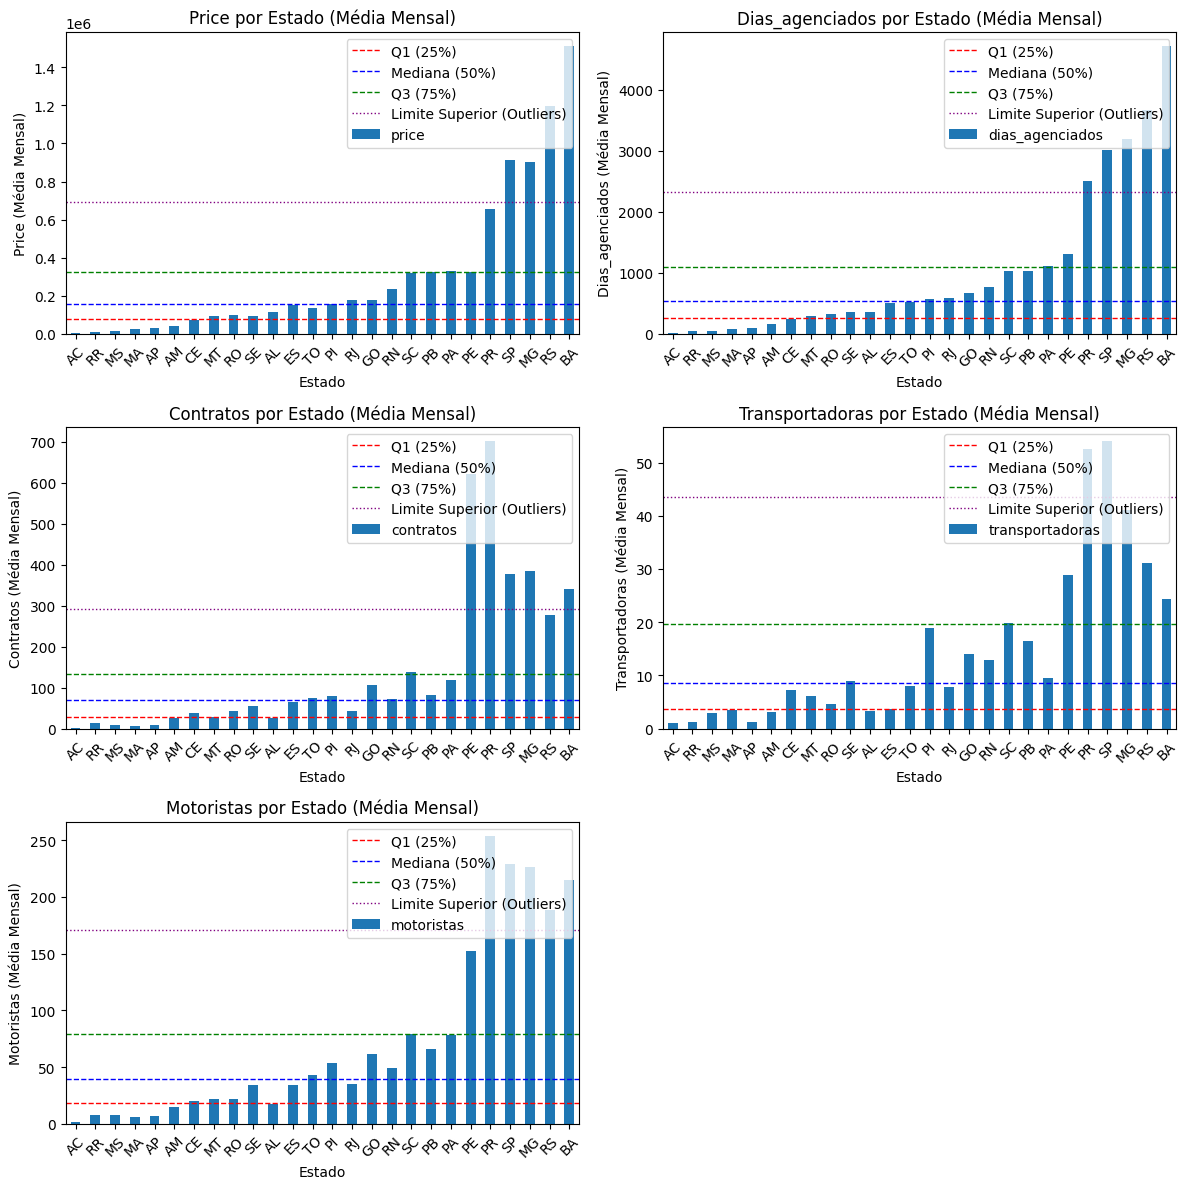

In [11]:
# distribuição dos estados originais

metricas = ['price', 'dias_agenciados', 'contratos', 'transportadoras', 'motoristas']


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = mensal_estado[metrica].quantile(0.25)
    q2 = mensal_estado[metrica].median()
    q3 = mensal_estado[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    mensal_estado.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


## distribuição mapa

In [4]:
from geobr import read_state
# Carregar a geometria dos estados do Brasil
states_gdf = read_state(year=2020)

# Unir os dados dos estados com as geometrias
states_gdf = states_gdf.merge(mensal_estado, left_on="abbrev_state", right_on="estado")

# Criar subplots para dois mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
states_gdf.plot(
    column="price",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=axes[0],
    edgecolor="0.8",
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
axes[0].set_title("Mapa de Calor dos Estados - Valor Total dos Contratos", fontsize=15)
axes[0].axis("off")

# Mapa de calor para 'dias_agenciados'
states_gdf.plot(
    column="dias_agenciados",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[1],
    edgecolor="0.8",
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
axes[1].set_title("Mapa de Calor dos Estados - Dias Agenciados", fontsize=15)
axes[1].axis("off")

# Ajustar layout e exibir os gráficos
plt.tight_layout()
plt.show()


/home/deboragomes/.local/share/virtualenvs/debora-a-xJ3oPA/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()


NameError: name 'mensal_estado' is not defined

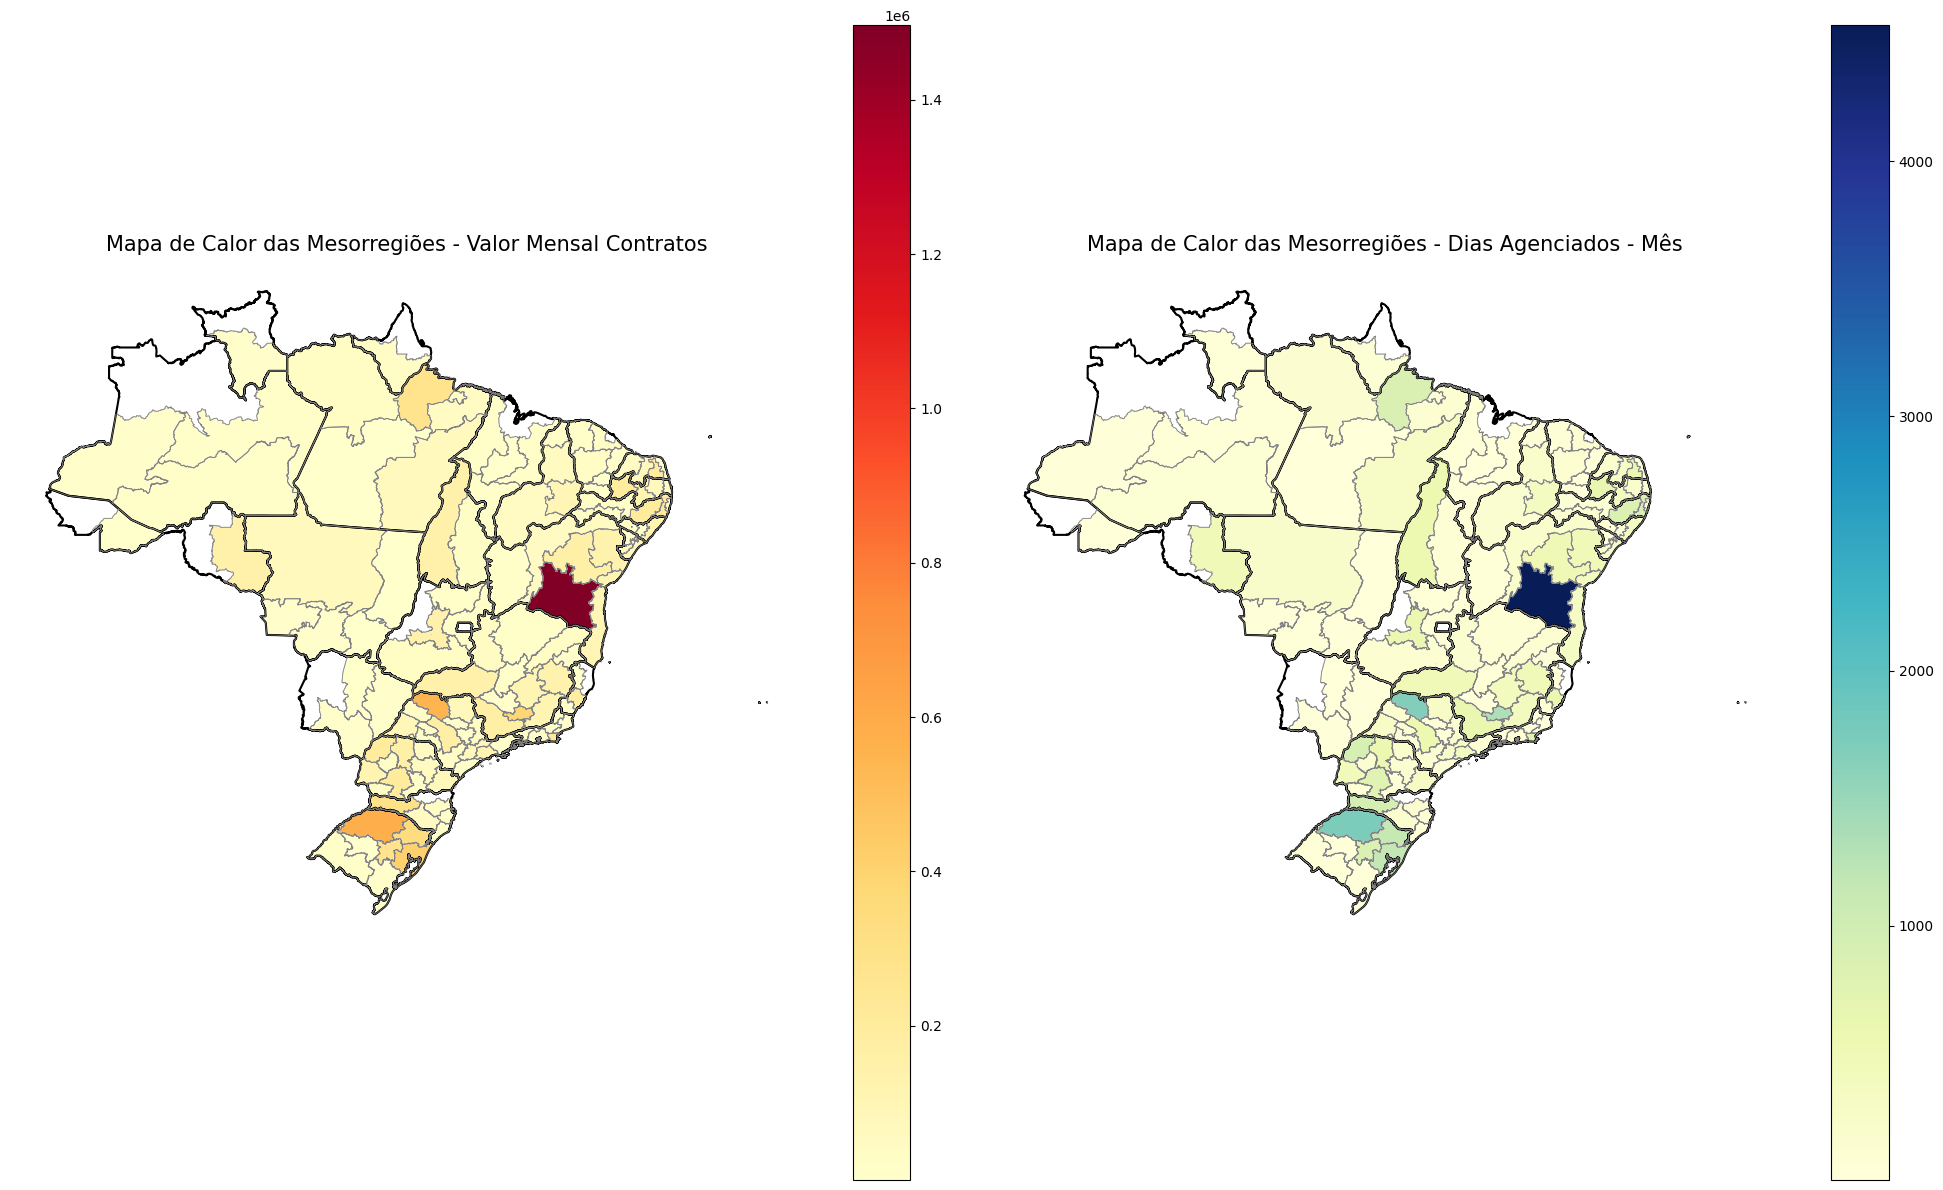

In [78]:


# Load Brazilian states shapefile using geobr
states_gdf = read_state(year=2020)

# Create subplots for side-by-side maps
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 row, 2 columns

# Plot Heatmap for 'price'
gdf_mesorregioes.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True
)
states_gdf.boundary.plot(ax=axes[0], color='black', linewidth=1.5)
gdf_mesorregioes.boundary.plot(ax=axes[0], color='gray', linewidth=0.5)
axes[0].set_title('Mapa de Calor das Mesorregiões - Valor Mensal Contratos', fontsize=15)
axes[0].axis('off')

# Plot Heatmap for 'dias_agenciados'
gdf_mesorregioes.plot(
    column='dias_agenciados',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True
)
states_gdf.boundary.plot(ax=axes[1], color='black', linewidth=1.5)
gdf_mesorregioes.boundary.plot(ax=axes[1], color='gray', linewidth=0.5)
axes[1].set_title('Mapa de Calor das Mesorregiões - Dias Agenciados - Mês', fontsize=15)
axes[1].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## estados_classificados

In [12]:
# classificanco os estados
estados_classificados = mensal_estado.copy()

def categorizar(valor, q1, q2, q3, upper_bound
):
    if valor < q1:
        return 'Muito Baixo'
    elif q1 <= valor < q2:
        return 'Baixo'
    elif q2 <= valor < q3:
        return 'Médio'
    elif q3 <= valor < upper_bound:
        return 'Alto'
    else:
        return 'Muito Alto'

# Para cada variável, calculando os quartis e aplicando a função de categorização
metricas = ['price', 'dias_agenciados', 'contratos', 'transportadoras', 'motoristas']
for metrica in metricas:
    q1 = estados_classificados[metrica].quantile(0.25)
    q2 = estados_classificados[metrica].median()
    q3 = estados_classificados[metrica].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    
    # Criando uma nova coluna para cada métrica com a categoria
    estados_classificados[f'{metrica}_categoria'] = estados_classificados[metrica].apply(categorizar, q1=q1, q2=q2, q3=q3, upper_bound=upper_bound)

estados_classificados


,estado,dias_agenciados,contratos,motoristas,transportadoras,price,price_categoria,dias_agenciados_categoria,contratos_categoria,transportadoras_categoria,motoristas_categoria
0,AC,6.2,1.80,1.20,1.00,1360.00,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo
1,RR,40.2,13.00,7.60,1.20,7940.60,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo
2,MS,46.8,8.40,7.40,3.00,13892.40,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo
3,MA,85.8,6.20,5.80,3.60,26027.80,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo
4,AP,92.0,10.33,6.67,1.33,32312.67,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo
5,AM,160.0,27.40,14.80,3.20,39121.00,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo,Muito Baixo
6,CE,244.6,38.40,20.00,7.20,71734.20,Muito Baixo,Muito Baixo,Baixo,Baixo,Baixo
7,MT,291.4,29.00,21.80,6.20,90670.80,Baixo,Baixo,Baixo,Baixo,Baixo
8,RO,329.2,42.40,22.20,4.60,100107.40,Baixo,Baixo,Baixo,Baixo,Baixo
9,SE,351.6,56.20,34.60,9.00,95552.20,Baixo,Baixo,Baixo,Médio,Baixo


## dividindo os top estados em 2 grupos

In [91]:
def dividindo_top_estados(df, state_col, meso_col, target_cols):

    grouped_data = []

    # Iterar sobre os estados únicos
    for state in df[state_col].unique():
        state_data = df[df[state_col] == state]
        
        group_1 = []
        group_2 = []
        group_1_totals = {col: 0 for col in target_cols}
        group_2_totals = {col: 0 for col in target_cols}

        state_data_sorted = state_data.sort_values(by=target_cols[0], ascending=False)

        # Dividir mesorregiões entre os dois grupos
        for _, row in state_data_sorted.iterrows():
            if sum(group_1_totals.values()) <= sum(group_2_totals.values()):
                group_1.append(row)
                for col in target_cols:
                    group_1_totals[col] += row[col]
            else:
                group_2.append(row)
                for col in target_cols:
                    group_2_totals[col] += row[col]

        # Adicionar resultados ao grupo final
        for row in group_1:
            grouped_data.append({**row.to_dict(), 'group_id': 1})
        for row in group_2:
            grouped_data.append({**row.to_dict(), 'group_id': 2})

    # Construir DataFrame final
    grouped_df = pd.DataFrame(grouped_data)
    return grouped_df


# Carregar os dados de mesorregiões dos estados principais
top_estados = mensal_meso[mensal_meso['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR'])]

# Aplicar a função para dividir os estados
meso_total = dividindo_top_estados(
    top_estados, 
    state_col='estado', 
    meso_col='meso', 
    target_cols=['contratos', 'price', 'dias_agenciados','transportadoras', 'motoristas']
)

# Resumo por grupo e estado
meso_resumo = meso_total.groupby(['estado', 'group_id'])[['contratos', 'price', 'dias_agenciados','transportadoras', 'motoristas']].sum().reset_index()
meso_resumo['estado'] = meso_resumo['estado'].astype(str) + meso_resumo['group_id'].astype(str)
meso_resumo = meso_resumo.drop(columns=['group_id'])

# Exibir os resultados
print("Resumo dos totais por grupo e estado:")
print('meso_resumo')
display(meso_resumo)

print("Resumo detalhado por mesorregião:")
meso_total['estado'] = meso_total['estado'].astype(str) + meso_total['group_id'].astype(str)
meso_total = meso_total.drop(columns=['group_id'])
print("meso_total")
display(meso_total.head(3))

Resumo dos totais por grupo e estado:
meso_resumo


,estado,contratos,price,dias_agenciados,transportadoras,motoristas
0,BA1,208.33,1496563.67,4534.33,12.33,172.33
1,BA2,208.68,562304.99,1912.01,24.34,107.33
2,MG1,313.99,571335.84,2065.01,43.33,178.83
3,MG2,163.66,612370.33,2103.00,11.99,109.66
4,PR1,674.67,443415.67,1846.66,39.33,218.67
5,PR2,364.33,493508.67,1792.66,32.00,143.33
6,RS1,195.00,846345.66,2570.00,27.33,126.33
7,RS2,160.00,777462.17,2410.84,17.49,117.33
8,SP1,214.84,638339.67,1998.34,30.34,131.33
9,SP2,262.66,640026.33,2181.00,53.68,170.65


Resumo detalhado por mesorregião:
meso_total


,estado,meso,dias_agenciados,contratos,motoristas,transportadoras,price,geometry
0,RS1,Noroeste Rio-grandense,1735.67,137.0,82.33,22.00,573683.33,"POLYGON ((-53.0167519139999 -29.155679731, -53..."
1,RS1,Centro Oriental Rio-grandense,834.33,58.0,44.00,5.33,272662.33,"POLYGON ((-52.0460455462042 -29.0577078495701,..."
2,RS2,Metropolitana de Porto Alegre,1165.67,76.0,62.33,6.33,413280.33,"(POLYGON ((-51.271899645 -30.03897208, -51.271..."


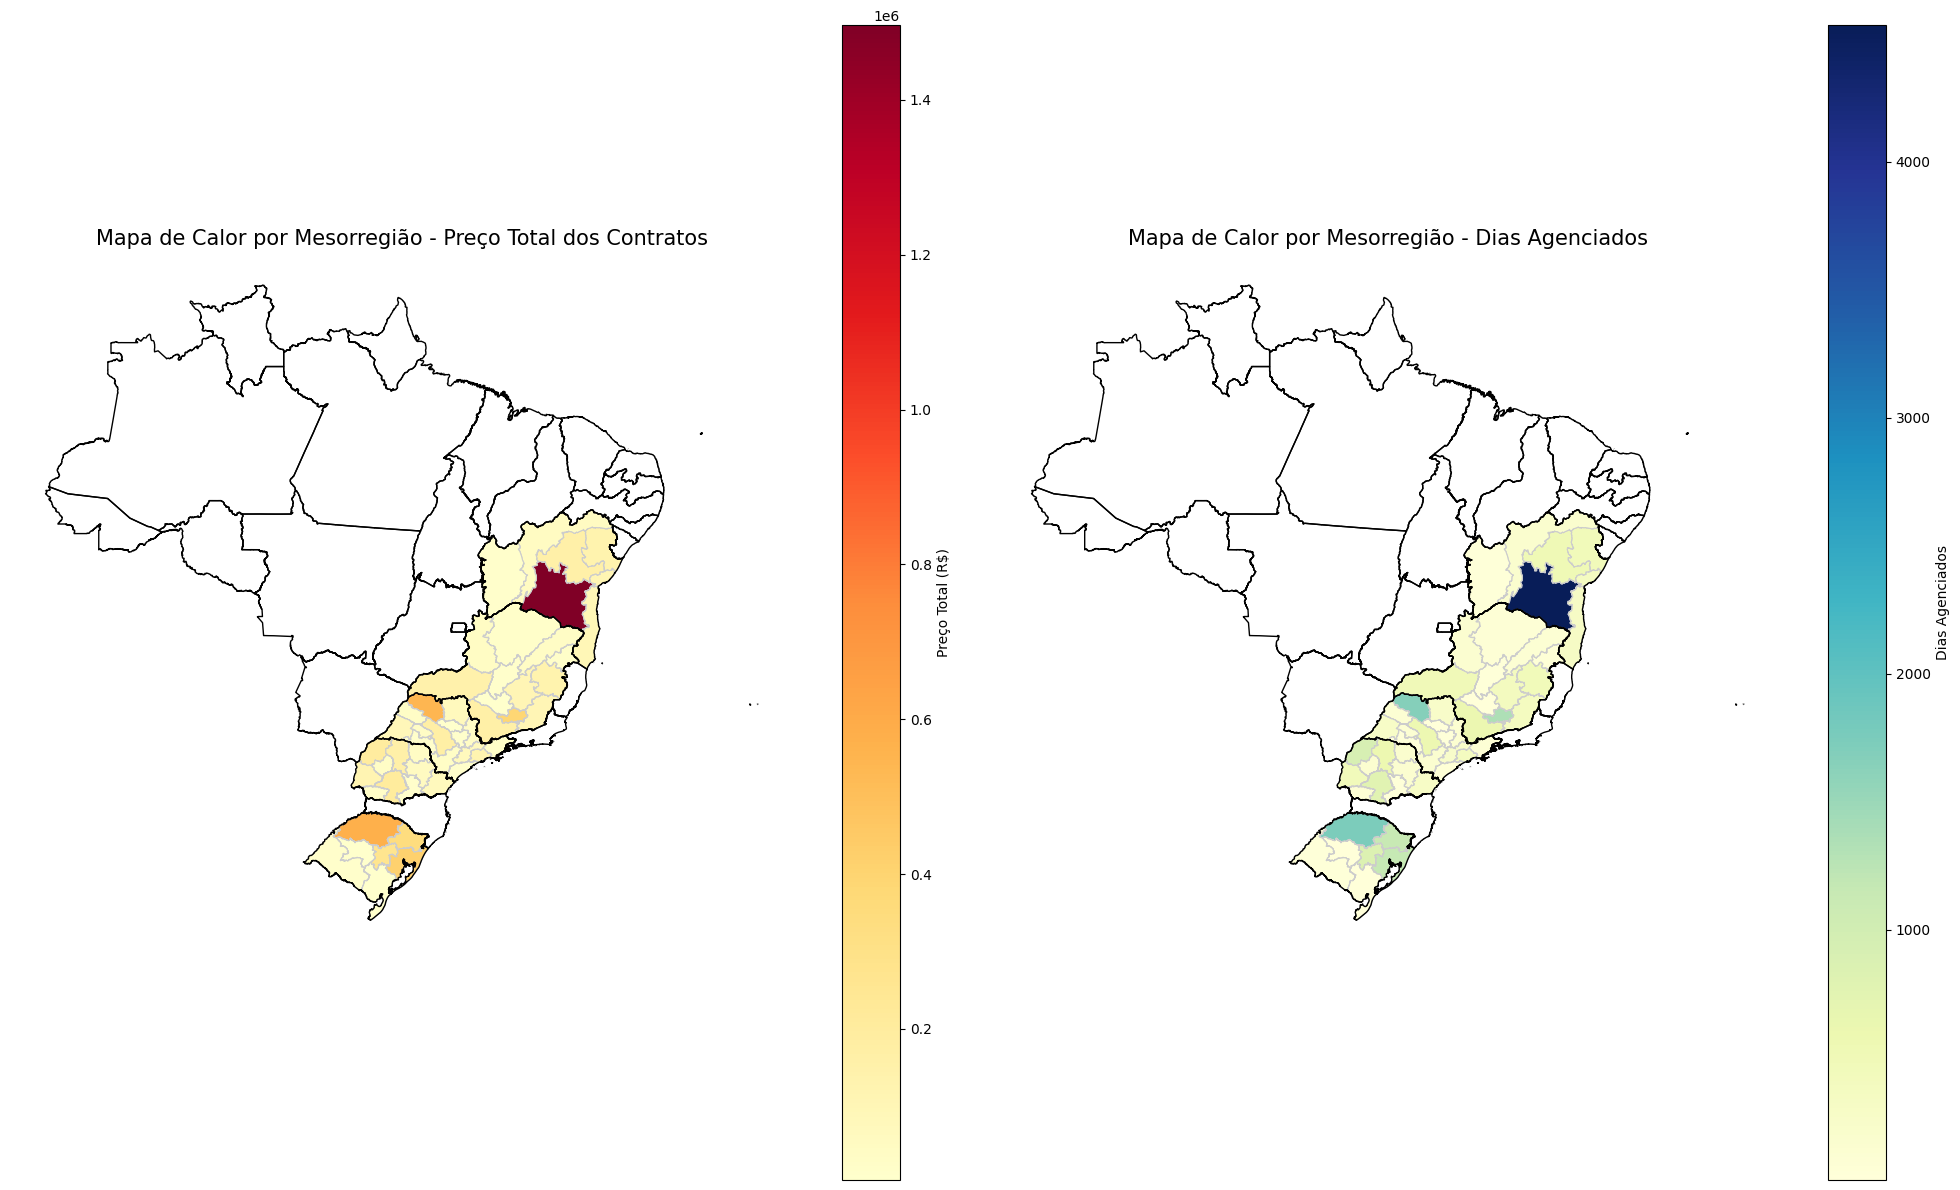

In [99]:
# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame e converter geometria de WKT para Shapely
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string antes de aplicar wkt.loads
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Carregar o shapefile dos estados (ajuste conforme necessário)
states_gdf = read_state(year=2020)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
# Plot dos estados sobre o mapa de preço
states_gdf.plot(
    ax=axes[0],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[0].set_title('Mapa de Calor por Mesorregião - Preço Total dos Contratos', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf.plot(
    column='dias_agenciados',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
# Plot dos estados sobre o mapa de dias agenciados
states_gdf.plot(
    ax=axes[1],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[1].set_title('Mapa de Calor por Mesorregião - Dias Agenciados', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


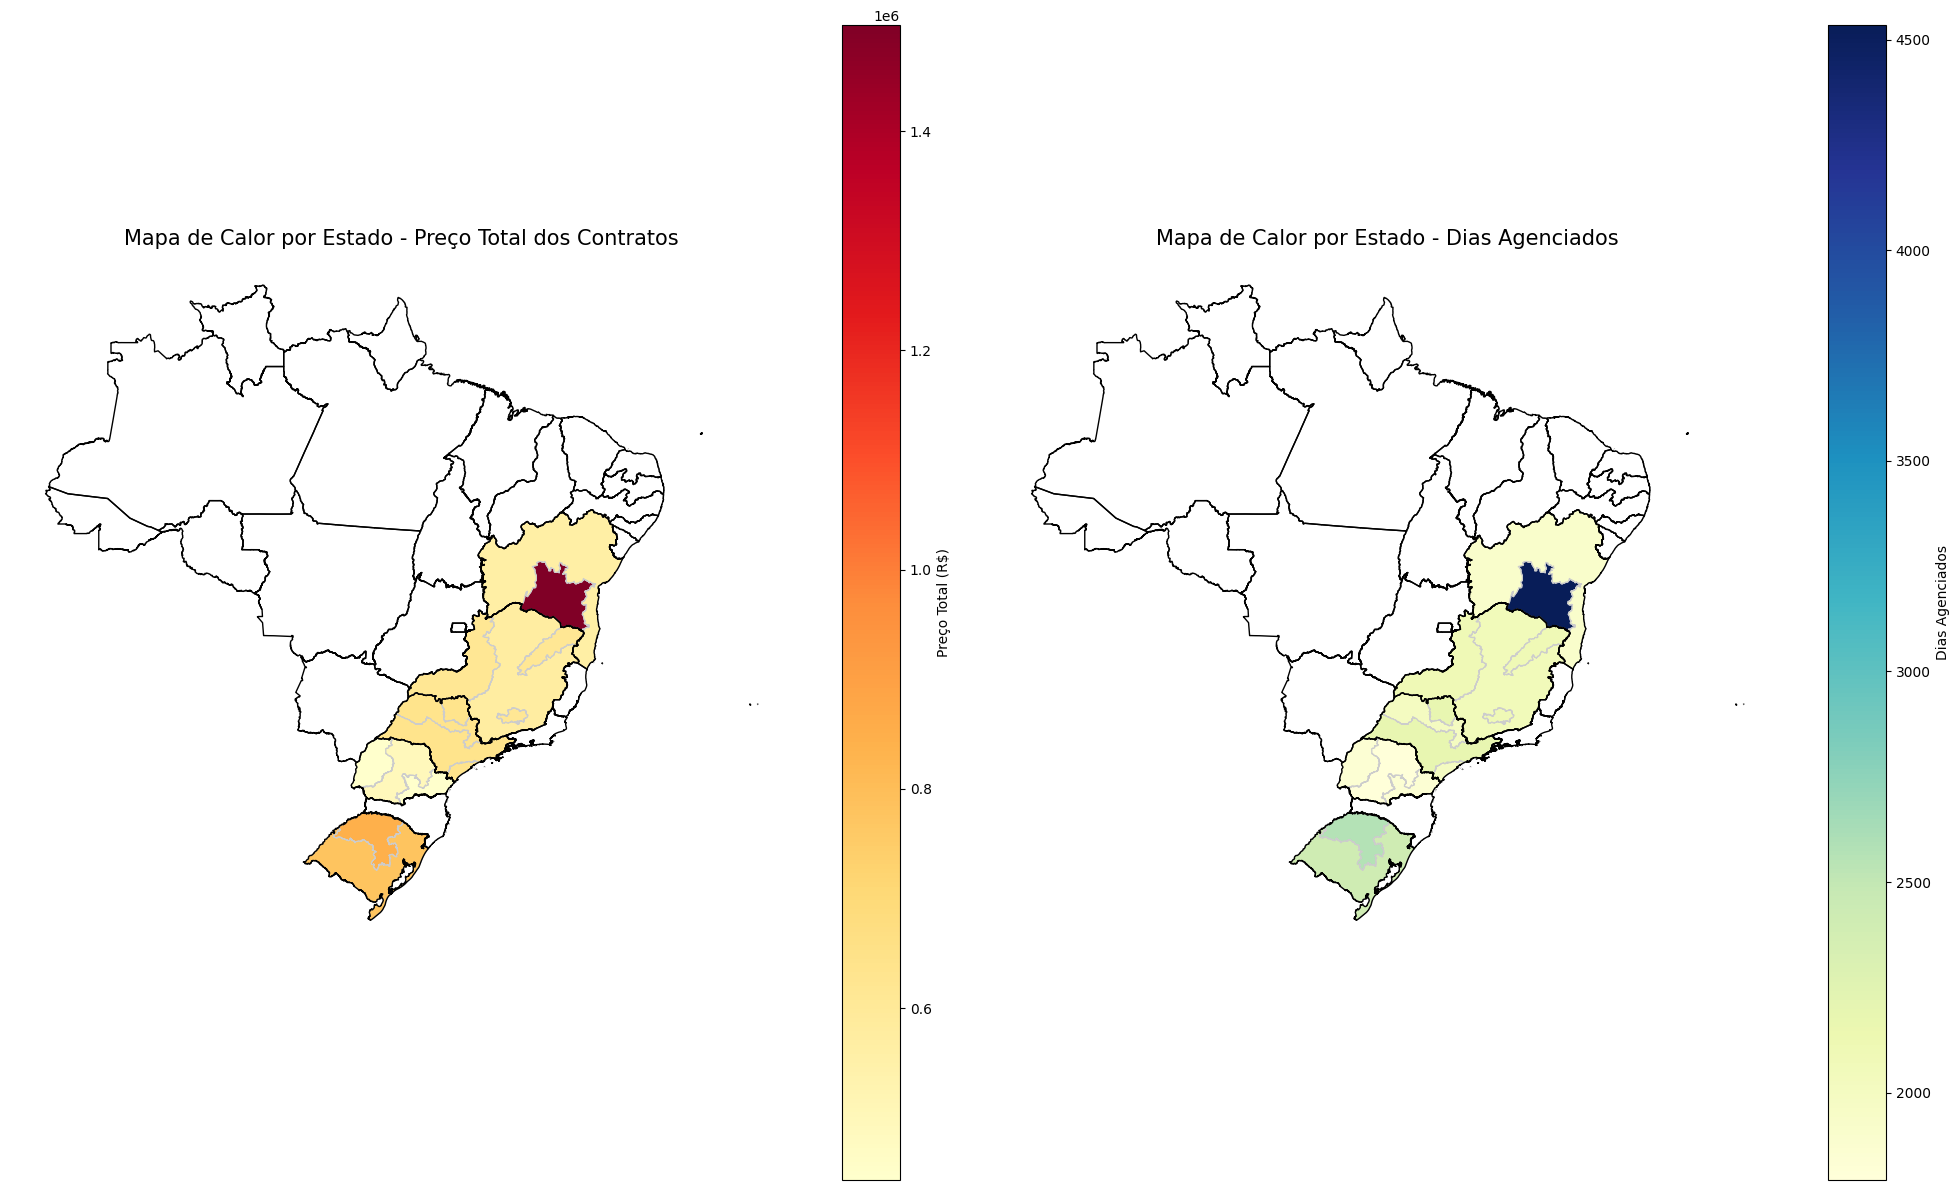

In [100]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string e converter para Shapely
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Agrupar por estado, somar colunas numéricas e unir as geometrias
gdf_grouped = gdf.dissolve(
    by='estado',
    aggfunc={
        'dias_agenciados': 'sum',
        'contratos': 'sum',
        'motoristas': 'sum',
        'transportadoras': 'sum',
        'price': 'sum'
    }
)

# Carregar o shapefile dos estados (ajuste conforme necessário)
states_gdf = read_state(year=2020)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf_grouped.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
# Plot dos estados sobre o mapa de preço
states_gdf.plot(
    ax=axes[0],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[0].set_title('Mapa de Calor por Estado - Preço Total dos Contratos', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf_grouped.plot(
    column='dias_agenciados',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
# Plot dos estados sobre o mapa de dias agenciados
states_gdf.plot(
    ax=axes[1],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[1].set_title('Mapa de Calor por Estado - Dias Agenciados', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


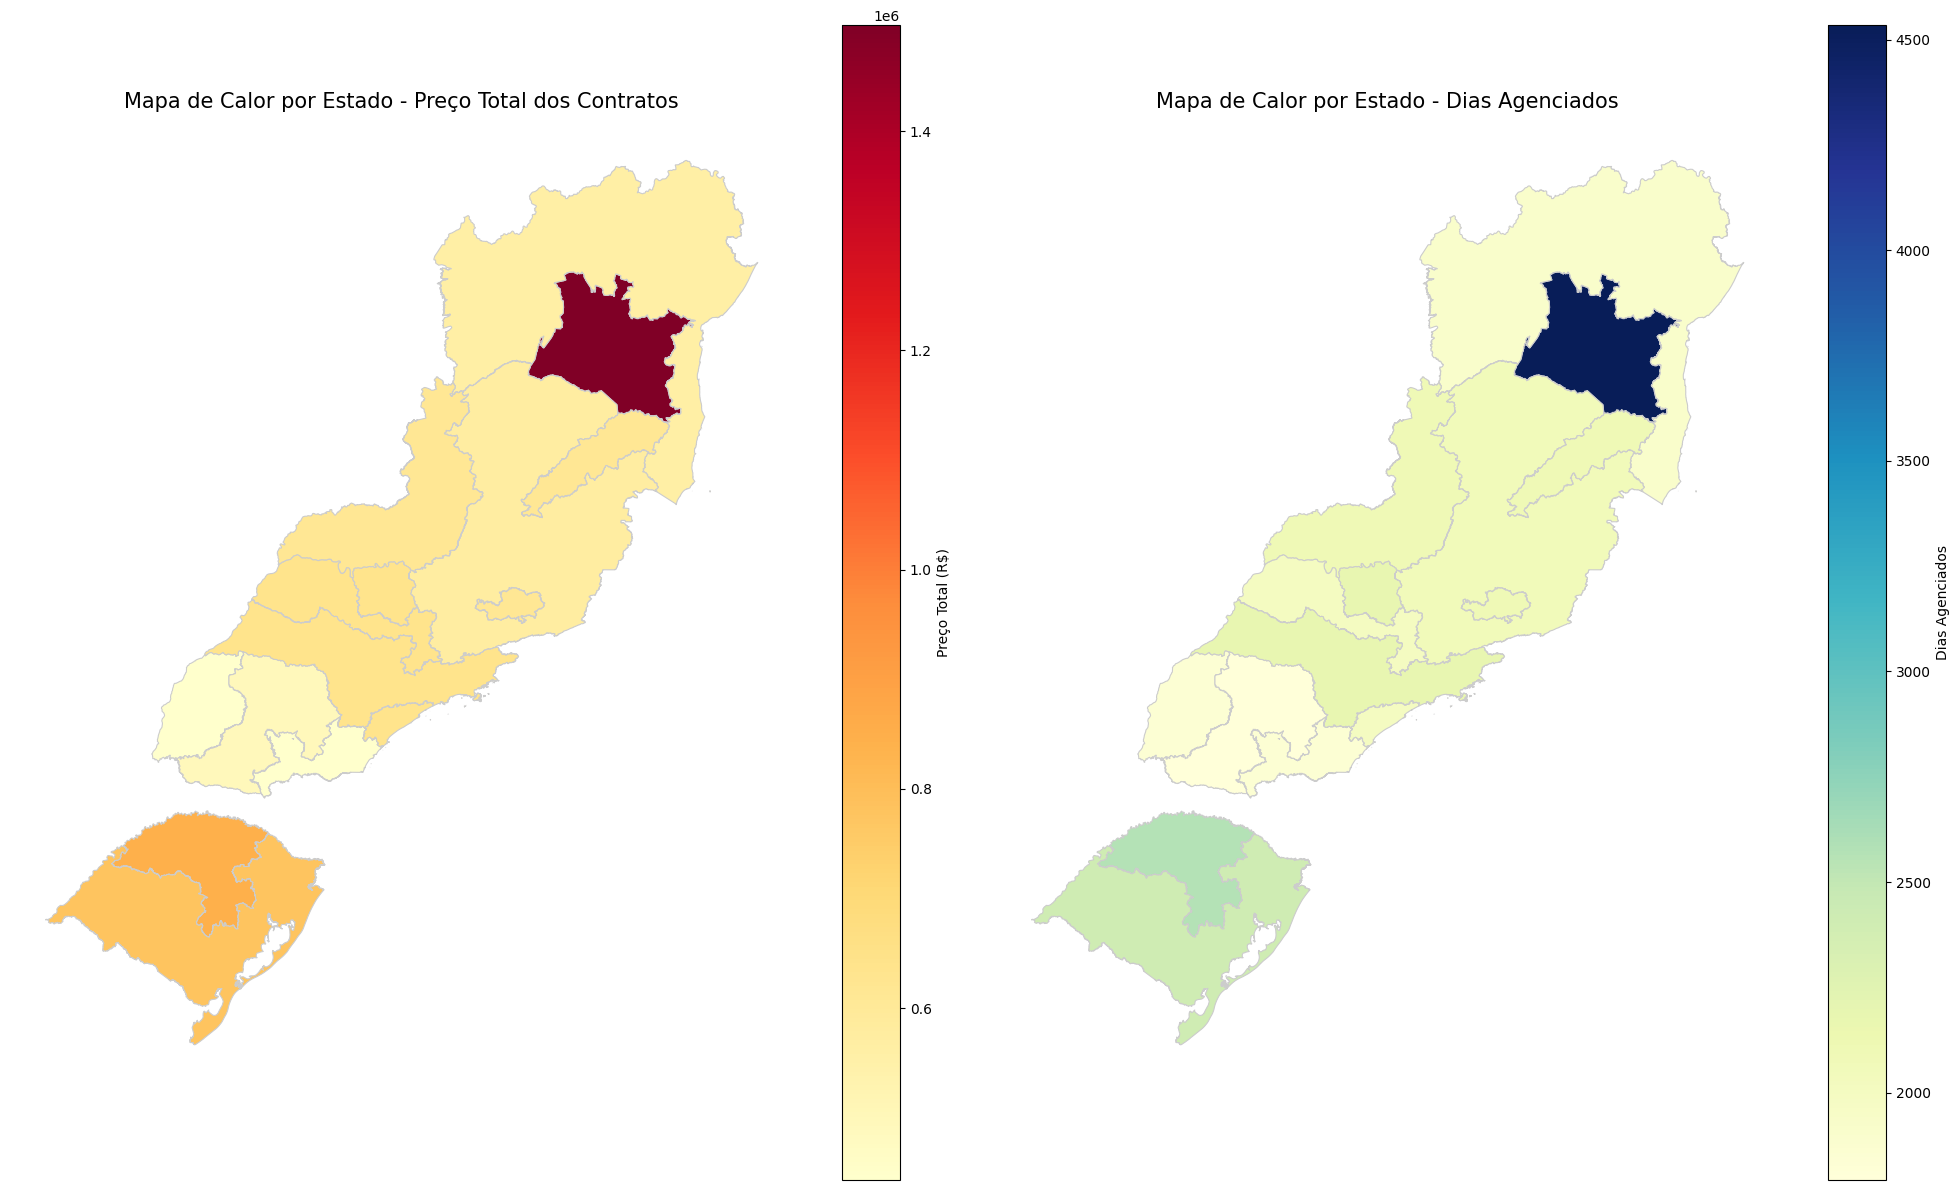

In [93]:

# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string e converter para Shapely
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Agrupar por estado, somar colunas numéricas e unir as geometrias
gdf_grouped = gdf.dissolve(
    by='estado',
    aggfunc={
        'dias_agenciados': 'sum',
        'contratos': 'sum',
        'motoristas': 'sum',
        'transportadoras': 'sum',
        'price': 'sum'
    }
)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf_grouped.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
axes[0].set_title('Mapa de Calor por Estado - Preço Total dos Contratos', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf_grouped.plot(
    column='dias_agenciados',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
axes[1].set_title('Mapa de Calor por Estado - Dias Agenciados', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


## ic_top_estados

In [15]:
# Função para calcular o intervalo de confiança
def calcular_ic(coluna, nivel_confianca=0.95):
    media = coluna.mean()
    erro_padrao = stats.sem(coluna)
    intervalo = stats.t.interval(nivel_confianca, len(coluna) - 1, loc=media, scale=erro_padrao)
    return media, intervalo[0], intervalo[1]

# Colunas para as quais calcular IC
colunas = ['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']

# Calcular IC para cada coluna
resultados = []
for coluna in colunas:
    media, limite_inferior, limite_superior = calcular_ic(meso_resumo[coluna])
    resultados.append({
        'Coluna': coluna,
        'IC Inferior': limite_inferior,
        'Média': media,    
        'IC Superior': limite_superior
    })

# Criar DataFrame com os resultados
ic_top_estados = pd.DataFrame(resultados)

# Exibir a tabela
ic_top_estados


,Coluna,IC Inferior,Média,IC Superior
0,contratos,208.219614,310.540833,412.862052
1,price,425017.904758,632067.249167,839116.593576
2,dias_agenciados,1551.821688,2120.348333,2688.874979
3,transportadoras,19.350181,27.569167,35.788152
4,motoristas,118.584559,141.426667,164.268774


## estados_dividos

In [17]:
estado_para_concat = mensal_estado[['estado', 'contratos', 'price', 'dias_agenciados','transportadoras', 'motoristas']]

# Filtrar 'estado' para eliminar os estados específicos
estado_filtrado = estado_para_concat[~estado_para_concat['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR', 'PE'])]

# Concatenar com group_totals
estados_divididos = pd.concat([estado_filtrado, meso_resumo], ignore_index=True)

# Exibir o DataFrame concatenado
estados_divididos


,estado,contratos,price,dias_agenciados,transportadoras,motoristas
0,AC,1.80,1360.00,6.20,1.00,1.20
1,RR,13.00,7940.60,40.20,1.20,7.60
2,MS,8.40,13892.40,46.80,3.00,7.40
3,MA,6.20,26027.80,85.80,3.60,5.80
4,AP,10.33,32312.67,92.00,1.33,6.67
5,AM,27.40,39121.00,160.00,3.20,14.80
6,CE,38.40,71734.20,244.60,7.20,20.00
7,MT,29.00,90670.80,291.40,6.20,21.80
8,RO,42.40,100107.40,329.20,4.60,22.20
9,SE,56.20,95552.20,351.60,9.00,34.60


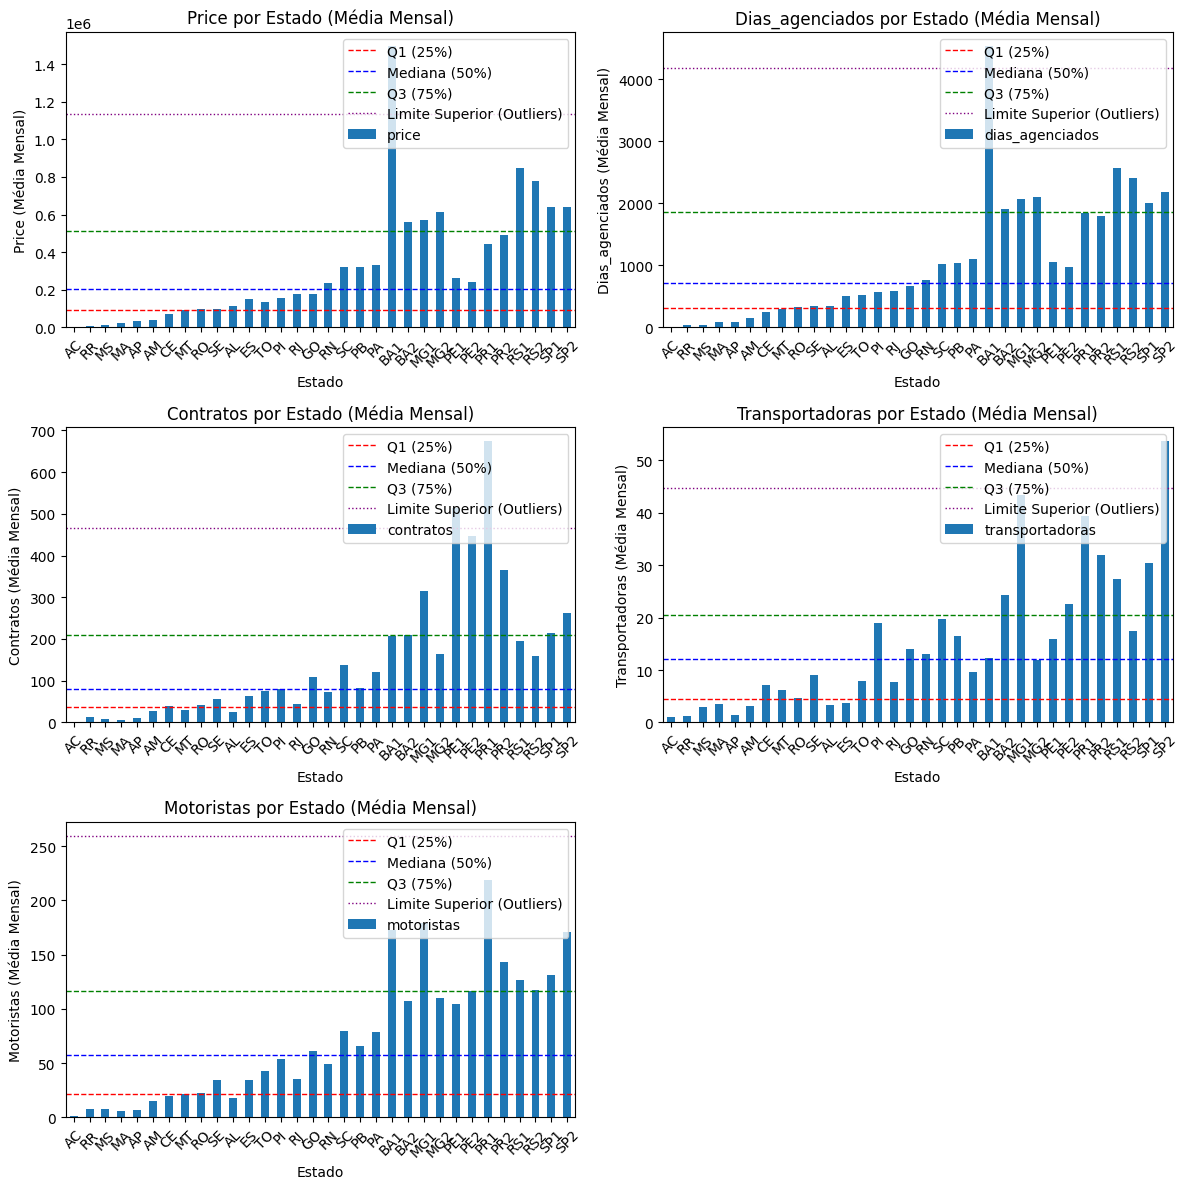

In [19]:


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = estados_divididos[metrica].quantile(0.25)
    q2 = estados_divididos[metrica].median()
    q3 = estados_divididos[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    estados_divididos.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# juntando estados menos ativos

In [20]:
ic_top_estados

,Coluna,IC Inferior,Média,IC Superior
0,contratos,208.219614,310.540833,412.862052
1,price,425017.904758,632067.249167,839116.593576
2,dias_agenciados,1551.821688,2120.348333,2688.874979
3,transportadoras,19.350181,27.569167,35.788152
4,motoristas,118.584559,141.426667,164.268774


In [54]:
menores = estados_divididos[['estado', 'contratos','price', 'dias_agenciados', 'transportadoras', 'motoristas']]

# Seleção das linhas para as regiões Norte, Nordeste, Centro-Oeste e Sudeste
linhas_selecionadas_norte = menores[menores['estado'].isin(['AC', 'AM', 'AP', 'RO', 'RR', 'PA'])]
linhas_selecionadas_nordeste = menores[menores['estado'].isin(['AL', 'CE', 'MA', 'PB', 'PI', 'RN','SE'])]
linhas_selecionadas_centro_oeste = menores[menores['estado'].isin(['GO', 'MS', 'MT','TO'])]
linhas_selecionadas_sudeste = menores[menores['estado'].isin(['ES', 'RJ'])]

# Somando as colunas selecionadas para a região Norte
soma_norte = linhas_selecionadas_norte[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_norte = linhas_selecionadas_norte['estado'].tolist()
estado_somado_norte = ', '.join(estados_norte)

# Somando as colunas selecionadas para a região Nordeste
soma_nordeste = linhas_selecionadas_nordeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_nordeste = linhas_selecionadas_nordeste['estado'].tolist()
estado_somado_nordeste = ', '.join(estados_nordeste)

# Somando as colunas selecionadas para a região Centro-Oeste
soma_centro_oeste = linhas_selecionadas_centro_oeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_centro_oeste = linhas_selecionadas_centro_oeste['estado'].tolist()
estado_somado_centro_oeste = ', '.join(estados_centro_oeste)

# Somando as colunas selecionadas para a região Sudeste (ES e RJ)
soma_sudeste = linhas_selecionadas_sudeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_sudeste = linhas_selecionadas_sudeste['estado'].tolist()
estado_somado_sudeste = ', '.join(estados_sudeste)

# Criando dicionários para as novas linhas
nova_linha_norte = {
    'estado': estado_somado_norte,
    'contratos': soma_norte['contratos'],
    'price': soma_norte['price'],
    'dias_agenciados': soma_norte['dias_agenciados'],
    'transportadoras': soma_norte['transportadoras'],
    'motoristas': soma_norte['motoristas']
}

nova_linha_nordeste = {
    'estado': estado_somado_nordeste,
    'contratos': soma_nordeste['contratos'],
    'price': soma_nordeste['price'],
    'dias_agenciados': soma_nordeste['dias_agenciados'],
    'transportadoras': soma_nordeste['transportadoras'],
    'motoristas': soma_nordeste['motoristas']
}

nova_linha_centro_oeste = {
    'estado': estado_somado_centro_oeste,
    'contratos': soma_centro_oeste['contratos'],
    'price': soma_centro_oeste['price'],
    'dias_agenciados': soma_centro_oeste['dias_agenciados'],
    'transportadoras': soma_centro_oeste['transportadoras'],
    'motoristas': soma_centro_oeste['motoristas']
}

nova_linha_sudeste = {
    'estado': estado_somado_sudeste,
    'contratos': soma_sudeste['contratos'],
    'price': soma_sudeste['price'],
    'dias_agenciados': soma_sudeste['dias_agenciados'],
    'transportadoras': soma_sudeste['transportadoras'],
    'motoristas': soma_sudeste['motoristas']
}

# Convertendo os dicionários em DataFrames
nova_linha_norte_df = pd.DataFrame([nova_linha_norte])
nova_linha_nordeste_df = pd.DataFrame([nova_linha_nordeste])
nova_linha_centro_oeste_df = pd.DataFrame([nova_linha_centro_oeste])
nova_linha_sudeste_df = pd.DataFrame([nova_linha_sudeste])

# Concatenando as novas linhas na tabela original
menores = pd.concat([menores, nova_linha_norte_df, nova_linha_nordeste_df, nova_linha_centro_oeste_df, nova_linha_sudeste_df], ignore_index=True)

# Excluindo as linhas selecionadas das regiões Norte, Nordeste, Centro-Oeste e Sudeste
menores = menores.drop(linhas_selecionadas_norte.index)
menores = menores.drop(linhas_selecionadas_nordeste.index)
menores = menores.drop(linhas_selecionadas_centro_oeste.index)
menores = menores.drop(linhas_selecionadas_sudeste.index)

# Exibindo as linhas das regiões Norte, Nordeste, Centro-Oeste e Sudeste que foram removidas
display(linhas_selecionadas_norte)
display(linhas_selecionadas_nordeste)
display(linhas_selecionadas_centro_oeste)
display(linhas_selecionadas_sudeste)

# Exibindo a tabela final
display(menores)

,estado,contratos,price,dias_agenciados,transportadoras,motoristas
0,AC,1.80,1360.00,6.2,1.00,1.20
1,RR,13.00,7940.60,40.2,1.20,7.60
4,AP,10.33,32312.67,92.0,1.33,6.67
5,AM,27.40,39121.00,160.0,3.20,14.80
8,RO,42.40,100107.40,329.2,4.60,22.20
19,PA,119.80,330759.40,1104.4,9.60,78.60


,estado,contratos,price,dias_agenciados,transportadoras,motoristas
3,MA,6.2,26027.8,85.8,3.6,5.8
6,CE,38.4,71734.2,244.6,7.2,20.0
9,SE,56.2,95552.2,351.6,9.0,34.6
10,AL,25.2,113842.0,352.8,3.4,17.8
13,PI,81.0,157401.6,569.4,19.0,53.6
16,RN,73.8,235511.4,758.8,13.0,49.0
18,PB,81.4,323528.8,1035.6,16.4,65.6


,estado,contratos,price,dias_agenciados,transportadoras,motoristas
2,MS,8.4,13892.4,46.8,3.0,7.4
7,MT,29.0,90670.8,291.4,6.2,21.8
12,TO,74.8,134980.6,518.8,8.0,43.0
15,GO,107.8,177304.6,673.8,14.0,61.6


,estado,contratos,price,dias_agenciados,transportadoras,motoristas
11,ES,64.6,151388.4,503.8,3.8,34.6
14,RJ,43.8,176549.2,582.2,7.8,35.2


,estado,contratos,price,dias_agenciados,transportadoras,motoristas
17,SC,138.80,321305.00,1026.20,19.80,79.40
20,BA1,208.33,1496563.67,4534.33,12.33,172.33
21,BA2,208.68,562304.99,1912.01,24.34,107.33
22,MG1,313.99,571335.84,2065.01,43.33,178.83
23,MG2,163.66,612370.33,2103.00,11.99,109.66
24,PE1,514.66,264144.66,1053.33,16.00,105.00
25,PE2,445.67,238989.33,977.00,22.67,116.33
26,PR1,674.67,443415.67,1846.66,39.33,218.67
27,PR2,364.33,493508.67,1792.66,32.00,143.33
28,RS1,195.00,846345.66,2570.00,27.33,126.33


In [55]:
# Verificar se os valores estão nos intervalos
resultados = []
for coluna in ic_top_estados['Coluna']:
    ic_inferior = ic_top_estados.loc[ic_top_estados['Coluna'] == coluna, 'IC Inferior'].values[0]
    ic_superior = ic_top_estados.loc[ic_top_estados['Coluna'] == coluna, 'IC Superior'].values[0]
    menores[f'{coluna}_no_IC'] = menores[coluna].apply(lambda x: ic_inferior <= x <= ic_superior)
    resultados.append(menores[[f'{coluna}_no_IC']].all().values[0])  # Checar se todos estão no IC

# Adicionar resultados gerais
menores['Dentro dos IC'] = menores[[f'{col}_no_IC' for col in ic_top_estados['Coluna']]].all(axis=1)

# Exibir os resultados
menores


,estado,contratos,price,dias_agenciados,transportadoras,motoristas,contratos_no_IC,price_no_IC,dias_agenciados_no_IC,transportadoras_no_IC,motoristas_no_IC,Dentro dos IC
17,SC,138.80,321305.00,1026.20,19.80,79.40,False,False,False,True,False,False
20,BA1,208.33,1496563.67,4534.33,12.33,172.33,True,False,False,False,False,False
21,BA2,208.68,562304.99,1912.01,24.34,107.33,True,True,True,True,False,False
22,MG1,313.99,571335.84,2065.01,43.33,178.83,True,True,True,False,False,False
23,MG2,163.66,612370.33,2103.00,11.99,109.66,False,True,True,False,False,False
24,PE1,514.66,264144.66,1053.33,16.00,105.00,False,False,False,False,False,False
25,PE2,445.67,238989.33,977.00,22.67,116.33,False,False,False,True,False,False
26,PR1,674.67,443415.67,1846.66,39.33,218.67,False,True,True,False,False,False
27,PR2,364.33,493508.67,1792.66,32.00,143.33,True,True,True,True,True,True
28,RS1,195.00,846345.66,2570.00,27.33,126.33,False,False,True,True,True,False


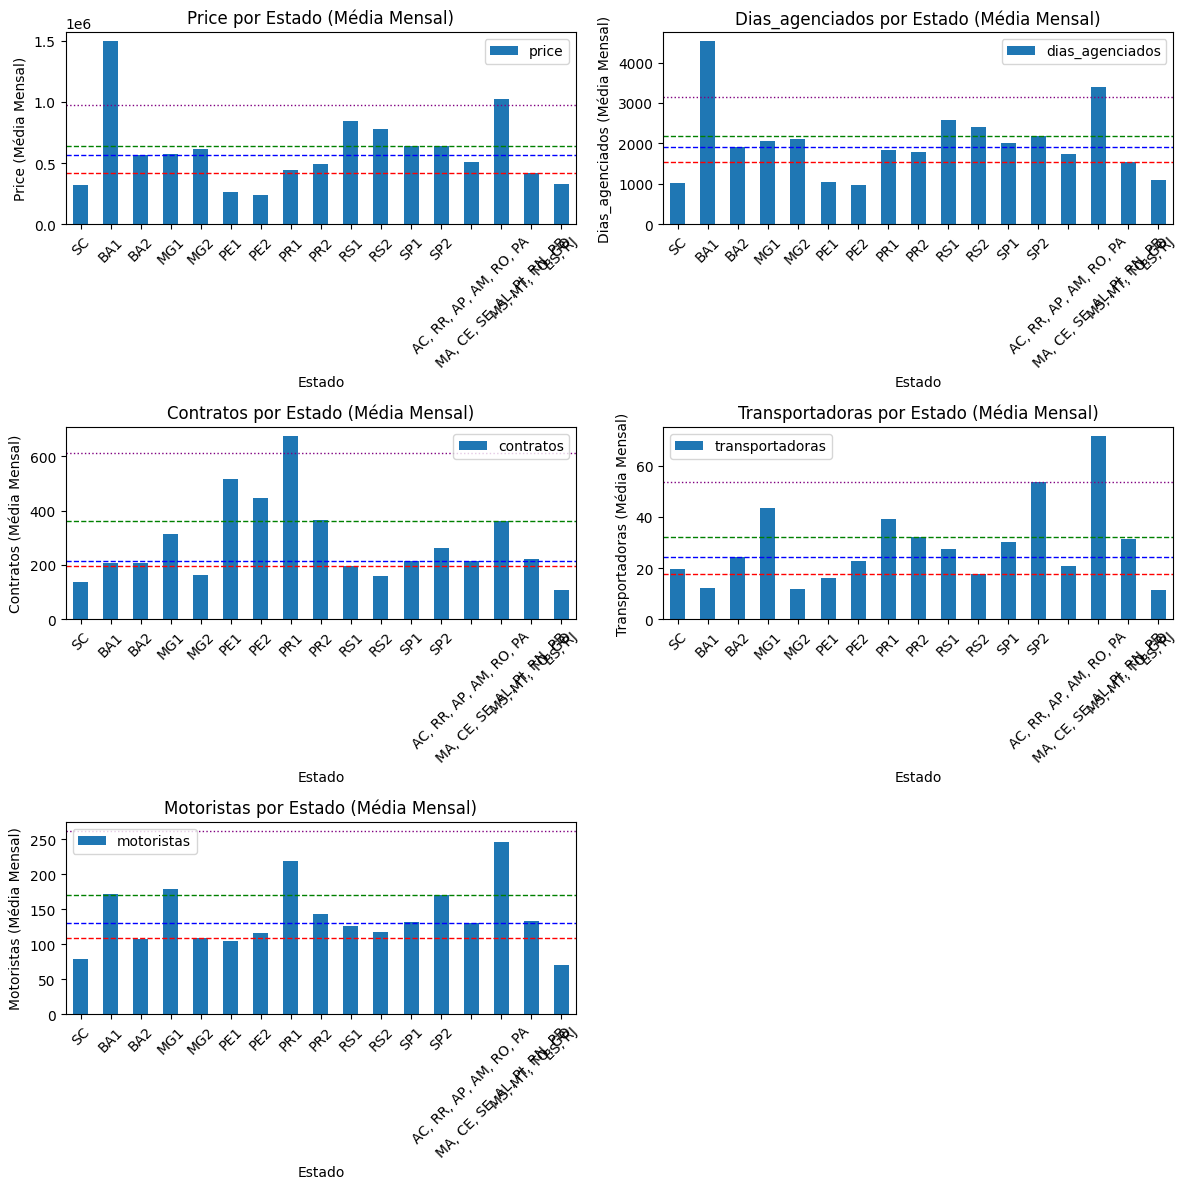

In [56]:

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = menores[metrica].quantile(0.25)
    q2 = menores[metrica].median()
    q3 = menores[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    menores.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    #axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# METRICA UNICA

In [48]:
metrica_unica = mensal_meso[['estado','meso' , 'dias_agenciados','price']]
metrica_unica

,estado,meso,dias_agenciados,price
0,MS,Centro Norte de Mato Grosso do Sul,1.00,120.00
1,AC,Vale do Acre,3.00,653.33
2,MT,Nordeste Mato-grossense,10.00,2200.00
3,ES,Noroeste Espírito-santense,11.00,2420.00
4,MA,Centro Maranhense,10.00,2766.00
...,...,...,...,...
120,MG,Campo das Vertentes,1346.33,385859.67
121,RS,Metropolitana de Porto Alegre,1165.67,413280.33
122,SP,São José do Rio Preto,1669.33,545324.67
123,RS,Noroeste Rio-grandense,1735.67,573683.33


In [50]:

importance_price = 0.568605  # Importância do price
importance_dias_agenciados = 0.391088  # Importância do dias_agenciados

participacao['metric'] = (participacao['price'] * importance_price) + (participacao['dias_agenciados'] * importance_dias_agenciados)

# Verificar o resultado
participacao[['estado', 'meso', 'dias_agenciados', 'price', 'metric']]

participacao

,estado,meso,dias_agenciados,price,proporcao_dias_agenciados_meso,proporcao_price_meso,funcionarios_dias_agenciados,funcionarios_price,metric
0,MS,Centro Norte de Mato Grosso do Sul,1.00,120.00,0.000027,0.000011,0.0,0.0,68.623688
1,AC,Vale do Acre,3.00,653.33,0.000081,0.000059,0.0,0.0,372.659969
2,MT,Nordeste Mato-grossense,10.00,2200.00,0.000270,0.000199,0.0,0.0,1254.841880
3,ES,Noroeste Espírito-santense,11.00,2420.00,0.000297,0.000219,0.0,0.0,1380.326068
4,MA,Centro Maranhense,10.00,2766.00,0.000270,0.000251,0.0,0.0,1576.672310
...,...,...,...,...,...,...,...,...,...
120,MG,Campo das Vertentes,1346.33,385859.67,0.036295,0.034961,0.0,0.0,219928.271167
121,RS,Metropolitana de Porto Alegre,1165.67,413280.33,0.031425,0.037446,0.0,0.0,235449.141589
122,SP,São José do Rio Preto,1669.33,545324.67,0.045003,0.049410,0.0,0.0,310727.188916
123,RS,Noroeste Rio-grandense,1735.67,573683.33,0.046791,0.051979,0.0,9.0,326878.009564


In [45]:
participacao = mensal_meso[['estado','meso' , 'dias_agenciados','price']]

# 1. Calcular o total de dias_agenciados e price por estado
total_dias_agenciados_meso = participacao.dias_agenciados.sum()
total_price_meso = participacao.price.sum()

# 2. Calcular a proporção por estado (normalizada para que a soma seja 1 por estado)
participacao['proporcao_dias_agenciados_meso'] = participacao['dias_agenciados'] / total_dias_agenciados_meso
participacao['proporcao_price_meso'] = participacao['price'] / total_price_meso

participacao

,estado,meso,dias_agenciados,price,proporcao_dias_agenciados_meso,proporcao_price_meso
0,MS,Centro Norte de Mato Grosso do Sul,1.00,120.00,0.000027,0.000011
1,AC,Vale do Acre,3.00,653.33,0.000081,0.000059
2,MT,Nordeste Mato-grossense,10.00,2200.00,0.000270,0.000199
3,ES,Noroeste Espírito-santense,11.00,2420.00,0.000297,0.000219
4,MA,Centro Maranhense,10.00,2766.00,0.000270,0.000251
...,...,...,...,...,...,...
120,MG,Campo das Vertentes,1346.33,385859.67,0.036295,0.034961
121,RS,Metropolitana de Porto Alegre,1165.67,413280.33,0.031425,0.037446
122,SP,São José do Rio Preto,1669.33,545324.67,0.045003,0.049410
123,RS,Noroeste Rio-grandense,1735.67,573683.33,0.046791,0.051979


In [46]:

# Número total de funcionários
num_funcionarios = 10

# 2. Calcular o número de funcionários para cada estado/mesorregião com base nas proporções
participacao['funcionarios_dias_agenciados'] = (participacao['proporcao_dias_agenciados_meso'] * num_funcionarios).round()
participacao['funcionarios_price'] = (participacao['proporcao_price_meso'] * num_funcionarios).round()

# Verificar os resultados
participacao[['estado', 'meso', 'proporcao_dias_agenciados_meso', 'proporcao_price_meso', 
              'funcionarios_dias_agenciados', 'funcionarios_price']]


#### 2. Ajuste da distribuição (se necessário):


# Ajuste caso a soma não seja 10
diferenca_dias_agenciados = num_funcionarios - participacao['funcionarios_dias_agenciados'].sum()
diferenca_price = num_funcionarios - participacao['funcionarios_price'].sum()

# Ajuste a diferença nos estados/mesorregiões com maior proporção (ou qualquer outro critério)
# Aqui estamos apenas adicionando a diferença ao maior valor
if diferenca_dias_agenciados > 0:
    participacao.loc[participacao['funcionarios_dias_agenciados'].idxmax(), 'funcionarios_dias_agenciados'] += diferenca_dias_agenciados
if diferenca_price > 0:
    participacao.loc[participacao['funcionarios_price'].idxmax(), 'funcionarios_price'] += diferenca_price

# Verifique novamente
participacao[['estado', 'meso', 'funcionarios_dias_agenciados', 'funcionarios_price']]


,estado,meso,funcionarios_dias_agenciados,funcionarios_price
0,MS,Centro Norte de Mato Grosso do Sul,0.0,0.0
1,AC,Vale do Acre,0.0,0.0
2,MT,Nordeste Mato-grossense,0.0,0.0
3,ES,Noroeste Espírito-santense,0.0,0.0
4,MA,Centro Maranhense,0.0,0.0
...,...,...,...,...
120,MG,Campo das Vertentes,0.0,0.0
121,RS,Metropolitana de Porto Alegre,0.0,0.0
122,SP,São José do Rio Preto,0.0,0.0
123,RS,Noroeste Rio-grandense,0.0,9.0


In [40]:
participacao = mensal_estado[['estado', 'dias_agenciados','price']]

# 1. Calcular o total de dias_agenciados e price por estado
total_dias_agenciados_estado = participacao.dias_agenciados.sum()
total_price_estado = participacao.price.sum()

# 2. Calcular a proporção por estado (normalizada para que a soma seja 1 por estado)
participacao['proporcao_dias_agenciados_estado'] = participacao['dias_agenciados'] / total_dias_agenciados_estado
participacao['proporcao_price_estado'] = participacao['price'] / total_price_estado

participacao

,estado,dias_agenciados,price,proporcao_dias_agenciados_estado,proporcao_price_estado
0,AC,6.2,1360.00,0.000228,0.000168
1,RR,40.2,7940.60,0.001479,0.000980
2,MS,46.8,13892.40,0.001722,0.001714
3,MA,85.8,26027.80,0.003156,0.003211
4,AP,92.0,32312.67,0.003384,0.003986
5,AM,160.0,39121.00,0.005886,0.004826
6,CE,244.6,71734.20,0.008998,0.008850
7,MT,291.4,90670.80,0.010720,0.011186
8,RO,329.2,100107.40,0.012110,0.012350
9,SE,351.6,95552.20,0.012934,0.011788


In [33]:
participacao.sample(20)

,estado,meso,dias_agenciados,price,proporcao_dias_agenciados_estado,proporcao_price_estado,proporcao_dias_agenciados_meso,proporcao_price_meso
79,PR,Centro Oriental Paranaense,145.67,54275.00,0.040027,0.057929,1.0,1.0
62,SP,Marília,116.67,35126.33,0.027916,0.027478,1.0,1.0
2,MT,Nordeste Mato-grossense,10.00,2200.00,0.031414,0.023471,1.0,1.0
71,PA,Nordeste Paraense,124.00,43088.00,0.084508,0.098587,1.0,1.0
97,PB,Borborema,383.67,122848.00,0.282389,0.288167,1.0,1.0
5,PA,Sudoeste Paraense,15.33,3390.00,0.010448,0.007756,1.0,1.0
17,SP,Araraquara,30.67,7637.00,0.007338,0.005974,1.0,1.0
60,SP,Araçatuba,110.67,33881.00,0.026480,0.026503,1.0,1.0
117,RS,Centro Oriental Rio-grandense,834.33,272662.33,0.167508,0.167915,1.0,1.0
106,MG,Sul/Sudoeste de Minas,605.00,167969.67,0.145153,0.141901,1.0,1.0


## mensal_meso

# TRATAMENTO VARIAVEIS

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Copiar os dados dos últimos 3 meses
data = contagem_mensal_uf.copy()

# Selecionar as variáveis relevantes
features = ['sum_dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'sum_price']

# Calcular a matriz de correlação
correlation_matrix = data[features].corr()

# Exibir a matriz de correlação
print('MATRIZ DE CORRELAÇÃO')
display(correlation_matrix)

# Visualizar a matriz de correlação usando um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlação')
plt.show()



In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Carregar os dados
dados = mensal_meso_updated[['qt_contratos', 'price']]

# Normalizar as métricas (0 a 1)
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(dados)

# Adicionar a normalização ao DataFrame
mensal_meso_updated['qt_contratos_norm'] = dados_normalizados[:, 0]
mensal_meso_updated['price_norm'] = dados_normalizados[:, 1]

# Calcular o índice ponderado com peso 50% para cada métrica
mensal_meso_updated['indice'] = 0.5 * mensal_meso_updated['qt_contratos_norm'] + 0.5 * mensal_meso_updated['price_norm']

# Aplicar clustering para criar grupos balanceados
num_funcionarios = 5  # Ajuste para o número de funcionários
kmeans = KMeans(n_clusters=num_funcionarios, random_state=42)
mensal_meso_updated['grupo'] = kmeans.fit_predict(mensal_meso_updated[['indice']])

# Verificar a distribuição
print(mensal_meso_updated.groupby('grupo')[['qt_contratos', 'price']].sum())


# DIVISÃO EM GRUPOS

- **Divisão em Grupos Principais e Estados Adicionais**:
  - A partir do `mensal_estado`, os grupos principais (`PR`, `SP`, `MG`, `RS`, `BA`) são separados diretamente para `principal_states`.
  - Os estados restantes são alocados ao `group_extra_states`.

- **Modelo de Otimização**:
  - Usa **Programação Linear Inteira Mista (MILP)** para alocar estados de `group_extra_states` nos grupos principais de forma a minimizar a diferença de `price` entre os grupos.

- **Vantagens da Otimização**:
  - **Automação**: Não é necessário criar manualmente os `DataFrames`.
  - **Flexibilidade**: Se os grupos principais mudarem, o código se ajusta automaticamente, usando `mensal_estado` como base.

## 5 GRUPOS POR ESTADO - PRICE

In [ ]:


mapa_estados = read_state(year=2020)

# Simula os dados do DataFrame states_groups_df novamente
states_data = {
    'estado': ['AC', 'RR', 'MS', 'AP', 'MA', 'AM', 'CE', 'MT', 'RO', 'AL', 'SE', 'ES', 'TO', 'PI', 'RJ', 'GO', 'RN', 'SC', 'PB', 'PA', 'PE', 'PR', 'SP', 'MG', 'RS', 'BA'],
    'grupo_estado': ['G4', 'G1', 'G1', 'G3', 'G2', 'G3', 'G5', 'G1', 'G2', 'G4', 'G2', 'G5', 'G4', 'G5', 'G2', 'G4', 'G3', 'G3', 'G2', 'G3', 'G5', 'G3', 'G5', 'G2', 'G4', 'G1']
}
states_groups_df = pd.DataFrame(states_data)

# Simula os dados do DataFrame group_summary_with_states para a tabela
group_summary_with_states = pd.DataFrame({
    'grupo': ['G1', 'G2', 'G3', 'G4', 'G5'],
    'price': [1932706.50, 1932609.50, 1932490.92, 1932232.50, 1932534.75],
    'estado': [['BA', 'RR', 'MS', 'MT'], ['MG', 'MA', 'RO', 'SE', 'RJ', 'PB'], ['PR', 'AP', 'AM', 'RN', 'SC', 'PA'], ['RS', 'AC', 'AL', 'TO', 'GO'], ['SP', 'CE', 'ES', 'PI', 'PE']],
    'dias_agenciados': [6071.75, 6639.0, 6785.5, 6206.0, 6757.0],
    'qt_contratos': [464.75, 729.25, 1291.08, 578.75, 1442.5]
})

# Faz o merge do mapa com os dados dos grupos, considerando a coluna 'abbrev_state'
mapa_estados = mapa_estados.merge(states_groups_df, left_on='abbrev_state', right_on='estado')

# Define as cores dos grupos
group_colors = {
    'G1': '#66c2a5',
    'G2': '#fc8d62',
    'G3': '#8da0cb',
    'G4': '#e78ac3',
    'G5': '#a6d854'
}

# Criação do gráfico e da tabela ao lado, agora ajustando o tamanho e adicionando cores correspondentes na tabela
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2, 1]})

# Plota os estados por grupo com as cores definidas
for group, color in group_colors.items():
    subset = mapa_estados[mapa_estados['grupo_estado'] == group]
    subset.plot(ax=ax1, color=color, label=group)

# Configurações do mapa
ax1.set_title('Distribuição dos Estados por Grupo')
ax1.axis('off')
ax1.legend(title="Grupos", loc='lower left')

# Cria a tabela ao lado do mapa, agora com cores correspondentes aos grupos
ax2.axis('off')
table_data = group_summary_with_states[['grupo',  'estado','price', 'dias_agenciados', 'qt_contratos','qt_motoristas', 'qt_transportadoras' ]]
row_colors = [group_colors[row['grupo']] for _, row in group_summary_with_states.iterrows()]
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center', rowColours=row_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

# Exibe o gráfico e a tabela
plt.tight_layout()
plt.show()


## 7 GRUPOS POR ESTADO - PRICE

In [ ]:

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Mantém BA e RS como grupos separados
ba_state = mensal_estado[mensal_estado['estado'] == 'BA'].reset_index(drop=True)
rs_state = mensal_estado[mensal_estado['estado'] == 'RS'].reset_index(drop=True)

target_price_ba = ba_state['price'].iloc[0]
target_price_rs = rs_state['price'].iloc[0]
target_price_avg = (target_price_ba + target_price_rs) / 2  # Valor de referência médio entre BA e RS

# Define os demais estados
remaining_states = mensal_estado[~mensal_estado['estado'].isin(['BA', 'RS'])].reset_index(drop=True)

# Definir um número menor de grupos para agrupar melhor os estados
num_groups = 5  # Reduzimos para tentar uma alocação mais equilibrada

# Cria o modelo de otimização
model = LpProblem("Group_Allocation_Improved", LpMinimize)

# Variáveis de decisão: Se o estado `j` é alocado ao grupo `g`
allocation_vars = {
    (j, g): LpVariable(f"assign_{j}_{g}", cat='Binary')
    for j in remaining_states.index for g in range(num_groups)
}

# Variáveis de desvio para representar a diferença entre `price` de cada grupo e o valor alvo (média de BA e RS)
deviation_vars = {g: LpVariable(f"deviation_{g}", lowBound=0) for g in range(num_groups)}

# Calcula o `price` total de cada grupo
price_vars = {g: lpSum(allocation_vars[j, g] * remaining_states.loc[j, 'price'] for j in remaining_states.index) for g in range(num_groups)}

# Função objetivo: Minimizar a soma dos desvios de `price` para cada grupo
model += lpSum(deviation_vars[g] for g in range(num_groups))

# Restrição 1: Cada estado em `remaining_states` deve ser atribuído a exatamente um grupo
for j in remaining_states.index:
    model += lpSum(allocation_vars[j, g] for g in range(num_groups)) == 1

# Restrição 2: As variáveis de desvio representam a diferença em relação ao valor alvo (média de BA e RS)
for g in range(num_groups):
    model += price_vars[g] - target_price_avg <= deviation_vars[g]
    model += target_price_avg - price_vars[g] <= deviation_vars[g]

# Restrição 3: Se um grupo não tiver nenhum estado atribuído, seu preço deve ser zero
for g in range(num_groups):
    model += price_vars[g] >= 0

# Resolve o modelo
model.solve()

# Exibe o status da solução
print("Status:", LpStatus[model.status])

# Exibe os resultados da alocação, garantindo que cada estado esteja apenas em um grupo
final_allocation = {'grupo': [], 'estados': []}
for g in range(num_groups):
    estados = [remaining_states.loc[j, 'estado'] for j in remaining_states.index if value(allocation_vars[j, g]) == 1]
    if len(estados) > 0:
        final_allocation['grupo'].append(f"G{g + 3}")  # G1 é BA e G2 é RS
        final_allocation['estados'].append(estados)

# Cria DataFrame da alocação dos grupos
final_allocation_df = pd.DataFrame(final_allocation)

# Inclui BA e RS no resultado final
final_allocation_df = pd.concat([
    pd.DataFrame({'grupo': ['G1'], 'estados': [['BA']]}),
    pd.DataFrame({'grupo': ['G2'], 'estados': [['RS']]}),
    final_allocation_df
], ignore_index=True)

# Calcula as métricas agregadas para cada grupo
final_groups = []

for index, row in final_allocation_df.iterrows():
    group_states = row['estados']
    group_data = mensal_estado[mensal_estado['estado'].isin(group_states)]
    
    # Calcula as métricas agregadas
    dias_agenciados = group_data['dias_agenciados'].sum()
    qt_contratos = group_data['qt_contratos'].sum()
    qt_motoristas = group_data['qt_motoristas'].sum()
    qt_transportadoras = group_data['qt_transportadoras'].sum()
    price = group_data['price'].sum()
    
    final_groups.append({
        'grupo': row['grupo'],
        'estados': group_states,
        'dias_agenciados': dias_agenciados,
        'qt_contratos': qt_contratos,
        'qt_motoristas': qt_motoristas,
        'qt_transportadoras': qt_transportadoras,
        'price': price
    })

# Cria DataFrame com as métricas agregadas e os estados de cada grupo
final_groups_df = pd.DataFrame(final_groups)

# Exibe o DataFrame final com os grupos e suas métricas agregadas
final_groups_df


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geobr import read_state
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Carrega o shapefile dos estados do Brasil usando geobr
mapa_estados = read_state(year=2020)

# Define os grupos iniciais e as suas respectivas métricas
group_summary_with_states = pd.DataFrame({
    'grupo': ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7'],
    'estado': [['BA'], ['RS'], ['MT', 'PB', 'PR'], ['RR', 'AL', 'SE', 'SP'], ['AM', 'RJ', 'MG'], ['AP', 'MA', 'CE', 'RO', 'TO', 'PI', 'RN', 'PE'], ['AC', 'MS', 'ES', 'GO', 'SC', 'PA']],
    'price': [1281010.5, 1428322.0, 1282093.25, 1326606.75, 1326969.0, 1296921.92, 1190593.75],
    'dias_agenciados': [5655.0, 4374.5, 4626.25, 4418.75, 4674.75, 4693.25, 4020.75],
    'qt_contratos': [406.25, 331.0, 995.0, 559.25, 542.5, 1145.58, 523.75],
    'qt_motoristas': [254.75, 223.5, 409.75, 335.25, 325.0, 418.17, 306.5],
    'qt_transportadoras': [27.5, 35.5, 88.0, 77.5, 58.75, 99.83, 57.25]
})

# Cria um dicionário de mapeamento de estados para os grupos
estado_grupo_mapping = {}
for index, row in group_summary_with_states.iterrows():
    for estado in row['estado']:
        estado_grupo_mapping[estado] = row['grupo']

# Adiciona a coluna 'grupo' ao GeoDataFrame do mapa de estados
mapa_estados['grupo'] = mapa_estados['abbrev_state'].map(estado_grupo_mapping)

# Define as cores dos grupos
group_colors = {
    'G1': '#ff9999',  # Cor rosa claro
    'G2': '#66b3ff',  # Cor azul claro
    'G3': '#99ff99',  # Cor verde claro
    'G4': '#ffcc99',  # Cor laranja claro
    'G5': '#c2c2f0',  # Cor lilás claro
    'G6': '#ffb3e6',  # Cor rosa mais claro
    'G7': '#c4e17f'   # Cor verde amarelado
}

# Criação do gráfico e da tabela ao lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [2.5, 1]})

# Plota os estados por grupo com as cores definidas
for group, color in group_colors.items():
    subset = mapa_estados[mapa_estados['grupo'] == group]
    if not subset.empty:
        subset.plot(ax=ax1, color=color, label=group)

# Configurações do mapa
ax1.set_title('Distribuição dos Estados por Grupo', fontsize=16)
ax1.axis('off')
ax1.legend(title="Grupos", fontsize=10, title_fontsize=12)

# Cria a tabela ao lado do mapa
ax2.axis('off')
col_colors = ['#f2f2f2'] * len(group_summary_with_states.columns)
row_colors = [group_colors[group] for group in group_summary_with_states['grupo']]
table_data = group_summary_with_states[['grupo', 'estado', 'price', 'dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras']]
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center', rowColours=row_colors, colColours=col_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

# Ajusta o layout
plt.tight_layout()
plt.show()


# DIVIDINDO PRINCIPAIS ESTADOS

In [ ]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd

# Função para otimizar a divisão dos grupos
def optimize_groups(df, state_col, meso_col, target_cols, num_groups=2):
    grouped_data = []

    for state in df[state_col].unique():
        state_data = df[df[state_col] == state].reset_index(drop=True)
        num_regions = len(state_data)
        
        # Ajustar para garantir mais de um grupo por estado
        num_groups = min(num_groups, num_regions)  # Garantir no máximo o número de grupos igual ao número de mesorregiões

        # Criar a função objetivo para minimizar a diferença entre grupos
        c = np.zeros(num_regions * num_groups)  # Minimizar diferença entre grupos
        c[:num_regions] = 1  # Penaliza os itens do primeiro grupo

        # Restrições para equilibrar os totais de cada coluna em cada grupo
        A_eq = np.zeros((len(target_cols), num_regions * num_groups))
        b_eq = []

        for idx, col in enumerate(target_cols):
            A_eq[idx, :num_regions] = state_data[col].values
            for g in range(1, num_groups):
                A_eq[idx, num_regions*g:num_regions*(g+1)] = -state_data[col].values
            b_eq.append(0)  # Totais devem ser iguais para cada variável

        bounds = [(0, 1)] * (num_regions * num_groups)  # Limites entre 0 e 1 (grupo 1 ou 2 ou mais)

        # Restrições para garantir que cada mesorregião seja atribuída a um único grupo
        A_ub = np.zeros((num_regions, num_regions * num_groups))
        for i in range(num_regions):
            for g in range(num_groups):
                A_ub[i, i + num_regions * g] = 1
        
        # Resolver o problema de otimização
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=[1]*num_regions, bounds=bounds, method='highs')
        
        # Verificar se a solução foi encontrada
        if res.success:
            group_assignments = np.round(res.x[:num_regions]).astype(int)  # Atribuição de grupo para cada mesorregião

            for i, row in state_data.iterrows():
                grouped_data.append({**row.to_dict(), 'group_id': group_assignments[i] + 1})
        else:
            print(f"Problema com otimização para o estado {state}: {res.message}")

    grouped_df = pd.DataFrame(grouped_data)
    return grouped_df

# Aplicar a função
top_estados = mensal_meso[mensal_meso['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR'])]
grouped_meso = optimize_groups(
    top_estados,
    state_col='estado',
    meso_col='meso',
    target_cols=['qt_contratos', 'price', 'dias_agenciados', 'qt_transportadoras', 'qt_motoristas'],
    num_groups=2  # Definindo o número de grupos como 2 (ou altere para 3)
)

# Resumo por grupo
group_totals = grouped_meso.groupby(['estado', 'group_id'])[['qt_contratos', 'price', 'dias_agenciados', 'qt_transportadoras', 'qt_motoristas']].sum().reset_index()
display(group_totals)



In [ ]:
grouped_meso